In [1]:
DATASET_PATH = "final_output_frames.csv"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-16 17:55:39.793359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742144139.816856   33769 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742144139.823579   33769 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 17:55:39.847382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:

if (not os.path.exists(DATASET_PATH)):
    print("Error: Dataset not found.")
    sys.exit()

In [7]:
df = pd.read_csv(DATASET_PATH, header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [8]:
print("Labels:", np.unique(labels_set))

Labels: ['Background_noise' 'Bicycle' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [9]:
dataset = dataset.reshape(dataset.shape[0], 25, 16, 1)
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (1131631, 25, 16, 1)
Labels shape: (1131631,)
Input shape: (25, 16, 1)


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [10]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


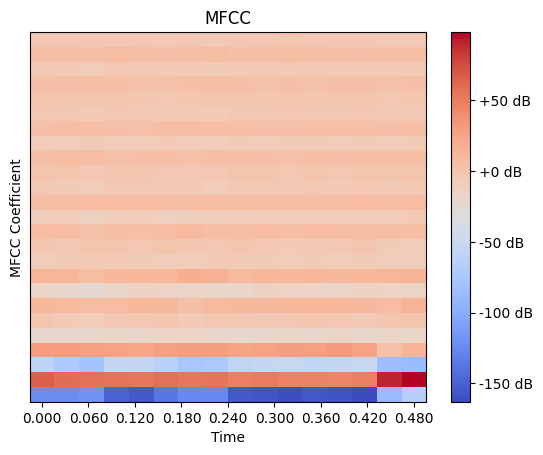

In [11]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [12]:
# Split the dataset into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 905304
Testing set length: 226327


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [14]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train_cat = to_categorical(label_encoder.fit_transform(y_train))
y_test_cat = to_categorical(label_encoder.fit_transform(y_test))

# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [15]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss']) 

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [16]:
from keras.callbacks import EarlyStopping

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.25,
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )
    # Print history
    if doPrintHistory: printHistory(history)

# Construct Sequantial Model

...

In [23]:
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

sequential_model = Sequential([

    Conv2D(filters=256, kernel_size=3, activation="relu", padding='same', input_shape=input_shape),
    Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),

    BatchNormalization(),
    MaxPool2D(pool_size=2),

    Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same'),

    BatchNormalization(),
    MaxPool2D(pool_size=2),

    GlobalAveragePooling2D(),  # Instead of Flatten

    Dense(512, activation="relu", kernel_regularizer=l2(0.0005)),
    Dropout(0.3),
    Dense(units=len(np.unique(labels_set)), activation="softmax")
])



In [18]:
def compileModel(model, learning_rate = 0.0003):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

In [24]:
compileModel(sequential_model, 0.0005)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 25, 16, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 8, 1024)    │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 8, 1024)    │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,076,038 (15.55 MB)

 Trainable params: 4,073,478 (15.54 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [25]:
fitModel(sequential_model, x_train, y_train_cat, 32, True, dist_class_weight, 1, 64)

Epoch 1/32


2025-03-16 18:02:25.143469: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[64,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,12,8,1024]{3,2,1,0}, f16[1024,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-16 18:02:25.143515: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[64,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,12,8,1024]{3,2,1,0}, f16[1024,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$con

10606/10610 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.1527 - loss: 1.8989

2025-03-16 18:05:03.064264: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[2,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[2,12,8,1024]{3,2,1,0}, f16[1024,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-16 18:05:03.067395: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[2,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[2,12,8,1024]{3,2,1,0}, f16[1024,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBac

10610/10610 ━━━━━━━━━━━━━━━━━━━━ 186s 17ms/step - categorical_accuracy: 0.1527 - loss: 1.8988 - val_categorical_accuracy: 0.0636 - val_loss: 1.7614
Epoch 2/32
 4704/10610 ━━━━━━━━━━━━━━━━━━━━ 1:23 14ms/step - categorical_accuracy: 0.1507 - loss: nan

KeyboardInterrupt: 

In [21]:
# Test the model.
test_loss, test_accuracy = sequential_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

7073/7073 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - categorical_accuracy: 0.4407 - loss: 1.3776
Test loss: 1.3778140544891357
Test accuracy: 0.4406721293926239


In [22]:
fitModel(sequential_model, x_train, y_train_cat, 32, True, dist_class_weight, 1, 64)

Epoch 1/32


2025-03-16 18:01:25.726864: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv (f16[64,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,12,8,256]{3,2,1,0}, f16[256,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-16 18:01:25.726923: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=3,k4=2,k5=3,k6=3,k7=2} for conv (f16[64,12,8,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,12,8,256]{3,2,1,0}, f16[256,3,3,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBac

   29/10610 ━━━━━━━━━━━━━━━━━━━━ 1:20 8ms/step - categorical_accuracy: 0.2644 - loss: 1.4729

KeyboardInterrupt: 